In [185]:
import os
import torch
from torch import nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.transforms import ToTensor, ToPILImage, Lambda
import matplotlib.pyplot as plt
import math
import autolens as al

from PIL import Image

import numpy as np
import pandas as pd
from torchvision.io import read_image

In [2]:
class CosmosimImageDataset(Dataset):
    def __init__(self, root, annotations_filename='labels.csv', img_dir='images', train=True, all=False, transform=None, target_transform=None):
        df = pd.read_csv('{0}/{1}'.format(root.rstrip('/'), annotations_filename.lstrip('/')))
        if all:
            self.img_labels = df
        elif train:
            self.img_labels = df.head(math.floor(0.8 * len(df)))
        else:
            self.img_labels = df.tail(len(df) - math.floor(0.8 * len(df)))
        self.img_dir = '{0}/{1}'.format(root.rstrip('/'), img_dir.lstrip('/'))
        self.transform = transform
        self.target_transform = target_transform
        self.classes = list(self.img_labels.iloc[: , 1:].columns)

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        labels = self.img_labels.iloc[idx, 1:]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            labels = self.target_transform(labels)
        return image.float(), labels.float()

In [3]:
def train_loop(dataloader, model, loss_fn, optimizer, device = None):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn, device = None):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"Test Error: \n, Avg loss: {test_loss:>8f} \n")

In [4]:
root = "__local/data/Cosmosim/4"
transform = transforms.Compose([
    transforms.Resize(256, antialias=None),
    transforms.CenterCrop(224),
    transforms.ToPILImage(),
    transforms.ToTensor()
])

training_data = CosmosimImageDataset(
    root=root,
    train=True,
    transform=transform,
    target_transform=Lambda(lambda y: torch.tensor(y.astype(float).values))
)

test_data = CosmosimImageDataset(
    root=root,
    train=False,
    transform=transform,
    target_transform=Lambda(lambda y: torch.tensor(y.astype(float).values))
)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [5]:
training_data.img_labels

,name,r_ein,rdsf_l,r_eff_l,x_l,y_l,ellx_l,elly_l,ellxl_l,ellyl_l,int_l,rdsf_s,r_eff_s,x_s,y_s,ellx_s,elly_s,int_s
0,tk6qae.png,2.262451,0.689088,1.264889,-0.824958,0.820932,0.160929,0.183897,0.391759,0.154880,0.860107,1.539666,0.850960,-0.096957,0.673100,-0.147332,-0.358746,1.407732
1,eyqryt.png,2.898916,0.566329,0.519144,0.974228,0.034047,-0.384250,-0.015714,-0.074328,-0.450373,1.137490,1.508203,1.709814,-0.458478,0.130690,-0.468016,-0.166950,1.476630
2,34ygqj.png,2.441840,0.694509,0.783642,0.724966,-0.767984,-0.084501,0.078019,-0.013385,-0.249690,0.990948,2.037549,0.994903,-0.235680,0.363034,-0.248342,-0.301507,1.561701
3,thblxg.png,2.781786,0.492175,0.666350,-0.445621,-0.365953,0.288982,-0.002667,0.263419,-0.197520,0.429062,1.821550,0.573331,-0.502695,0.086165,-0.461536,-0.246914,0.972377
4,af288o.png,2.875936,0.440319,1.575734,0.819377,0.813031,0.103442,-0.467333,-0.159902,-0.097089,0.662922,1.746128,0.773289,0.826859,-0.493665,0.473903,0.002023,1.722201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47995,a3gfet.png,2.930484,0.674753,0.758465,-0.427029,-0.276877,0.288153,-0.262398,-0.167914,0.020922,1.181850,2.282385,1.359553,0.145904,0.401588,-0.125237,0.270904,0.464601
47996,43ywob.png,1.226139,0.494291,0.084964,-0.957175,0.037067,-0.169023,-0.483370,0.063702,-0.158265,1.764909,2.125844,0.908828,-0.353208,0.336448,0.301867,-0.352393,1.699963
47997,89gd5b.png,2.421156,0.619826,0.661277,-0.501331,-0.778572,-0.098949,-0.354131,-0.060741,-0.384457,0.988829,2.059581,0.893620,-0.645677,-0.973459,-0.360502,0.190798,0.221735
47998,zvjjh3.png,1.119000,0.610631,1.438895,0.111999,0.339701,-0.416813,-0.183019,0.006745,0.125971,0.151222,2.122149,1.072446,-0.613763,0.723434,0.440890,0.359510,0.607642


In [6]:
test_data.img_labels

,name,r_ein,rdsf_l,r_eff_l,x_l,y_l,ellx_l,elly_l,ellxl_l,ellyl_l,int_l,rdsf_s,r_eff_s,x_s,y_s,ellx_s,elly_s,int_s
48000,xxnspz.png,1.984462,0.604294,0.077527,-0.372686,0.129991,0.284266,-0.265570,0.225264,0.134892,1.094284,1.946845,0.764052,-0.904274,-0.536850,0.224131,0.186406,1.626348
48001,pdkici.png,2.115296,0.692901,0.230077,-0.618015,0.410848,0.049832,0.393813,0.174637,-0.464608,1.363951,2.315877,1.878617,0.917101,-0.916415,0.320065,-0.336556,0.202452
48002,fjmzmj.png,1.589467,0.501901,1.310328,0.124435,-0.001553,-0.280883,0.250959,0.056222,-0.344655,0.984293,2.275408,1.978963,-0.756098,0.253197,-0.476185,-0.084188,1.947502
48003,mtd8fq.png,1.741642,0.665668,0.630621,-0.507072,-0.053701,-0.238447,-0.042220,0.069479,-0.049200,1.275869,1.585522,1.874407,0.016272,0.002553,0.295667,-0.492170,0.202120
48004,1no1t8.png,1.279331,0.562340,1.147676,0.422596,-0.184386,0.410939,0.443869,-0.148888,0.421895,0.582061,1.982140,1.167953,-0.124557,-0.162408,0.237441,0.314440,1.918801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,k283hm.png,2.735721,0.588737,1.404922,0.141041,0.503402,-0.170749,-0.325487,-0.140912,-0.360097,1.035282,2.180205,0.445149,-0.912879,-0.855483,0.239345,-0.335511,0.784271
59996,1yx3ck.png,2.096153,0.559333,1.083919,0.424789,0.754806,0.356569,0.257463,0.376217,-0.281638,0.969214,2.069146,0.880803,-0.907630,-0.399467,0.332649,-0.233546,1.078331
59997,cjsryc.png,2.436577,0.661158,0.368476,-0.788021,0.859553,0.354695,-0.175826,-0.309472,-0.178075,1.237042,1.739492,0.351413,0.538289,-0.364966,0.332153,-0.304934,1.552169
59998,c0osab.png,0.508822,0.576327,1.590505,0.689655,-0.366327,0.047015,-0.221215,0.402804,-0.132834,1.325015,1.594714,1.383578,0.502296,0.909065,0.265401,0.397048,1.389379


In [7]:
training_data.classes

['r_ein',
 'rdsf_l',
 'r_eff_l',
 'x_l',
 'y_l',
 'ellx_l',
 'elly_l',
 'ellxl_l',
 'ellyl_l',
 'int_l',
 'rdsf_s',
 'r_eff_s',
 'x_s',
 'y_s',
 'ellx_s',
 'elly_s',
 'int_s']

In [8]:
labels_map = training_data.img_labels.r_ein
labels_map

0        2.262451
1        2.898916
2        2.441840
3        2.781786
4        2.875936
           ...   
47995    2.930484
47996    1.226139
47997    2.421156
47998    1.119000
47999    0.904747
Name: r_ein, Length: 48000, dtype: float64

In [9]:
idx = 0
img, label = training_data[idx]
print(label)

tensor([ 2.2625,  0.6891,  1.2649, -0.8250,  0.8209,  0.1609,  0.1839,  0.3918,
         0.1549,  0.8601,  1.5397,  0.8510, -0.0970,  0.6731, -0.1473, -0.3587,
         1.4077])


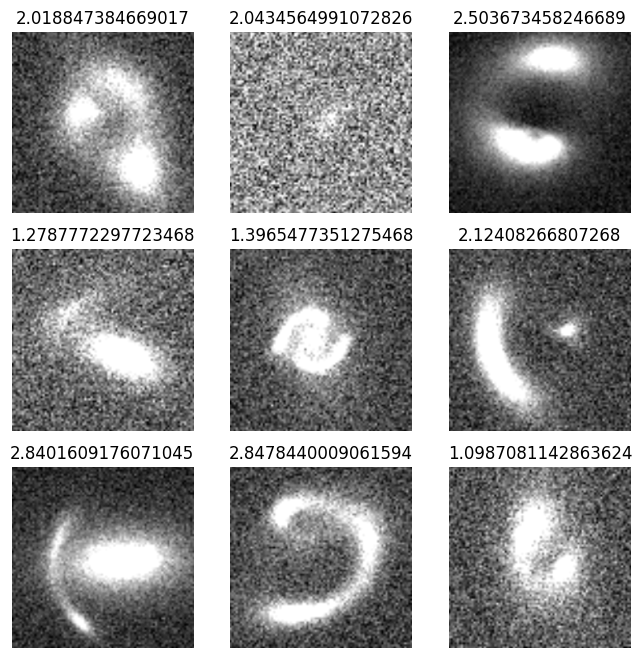

In [10]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[sample_idx])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [11]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 224, 224])
Labels batch shape: torch.Size([64, 17])


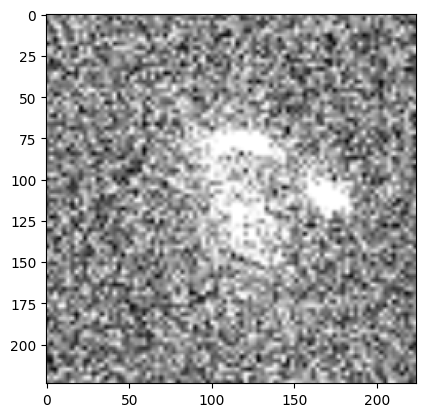

Label: tensor([ 1.7386,  0.6200,  1.5459, -0.3567,  0.2305,  0.4608, -0.3516, -0.2856,
        -0.2553,  0.2077,  1.7502,  0.2300,  0.2205,  0.8736, -0.0354,  0.3651,
         1.0099])


In [12]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [13]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [14]:
model = models.alexnet(weights='IMAGENET1K_V1')
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [15]:
model.features[0] = nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2)
model.classifier[6] = nn.Linear(4096, 17)

In [16]:
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [17]:
loss_fn = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
learning_rate = 1e-3
epochs = 10

In [18]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimiser, device)
    test_loop(test_dataloader, model, loss_fn, device)
print("Done!")

Epoch 1
-------------------------------
loss: 1.021179  [   64/48000]
loss: 0.182721  [ 6464/48000]
loss: 0.191479  [12864/48000]
loss: 0.167773  [19264/48000]
loss: 0.165848  [25664/48000]
loss: 0.154788  [32064/48000]
loss: 0.152037  [38464/48000]
loss: 0.134068  [44864/48000]
Test Error: 
, Avg loss: 0.125930 

Epoch 2
-------------------------------
loss: 0.131967  [   64/48000]
loss: 0.146991  [ 6464/48000]


KeyboardInterrupt: 

In [22]:
torch.save(model.state_dict(), '__local/models/model_alexnet_60k_ellcomps.pth')

### Evaluation

In [19]:
root = "__local/data/Cosmosim/test"
transform = transforms.Compose([
    transforms.Resize(256, antialias=None),
    transforms.CenterCrop(224),
    transforms.ToPILImage(),
    transforms.ToTensor()
])
test_data = CosmosimImageDataset(
    root=root,
    img_dir="images",
    all=True,
    transform=transform,
    target_transform=Lambda(lambda y: torch.tensor(y.astype(float).values))
)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [20]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

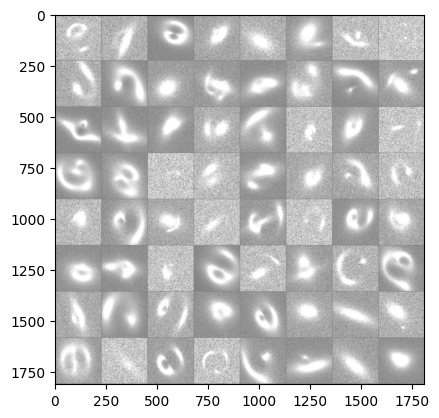

In [21]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

In [22]:
model = models.alexnet(weights='IMAGENET1K_V1')
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [23]:
model.features[0] = nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2)
model.classifier[6] = nn.Linear(4096, 17)

In [24]:
model_path = '__local/models/model_alexnet_60k_ellcomps.pth'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [89]:
def evaluate(dataloader, model, loss_fn, device = 'cpu'):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    preds = torch.empty((0,17))
    reals = torch.empty((0,17))
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            preds = torch.cat((preds, pred))
            reals = torch.cat((reals, y))

    return pd.DataFrame(preds), pd.DataFrame(reals)

In [90]:
loss_fn = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

In [91]:
preds, reals = evaluate(test_dataloader, model, loss_fn)

In [163]:
preds.iloc[0]

0     1.343415
1     0.508384
2     0.514670
3     0.818423
4     0.112994
5    -0.042301
6    -0.214983
7     0.103188
8     0.017540
9     0.496341
10    2.069089
11    1.780180
12   -0.177216
13    0.663122
14    0.195180
15    0.165848
16    1.544846
Name: 0, dtype: float32

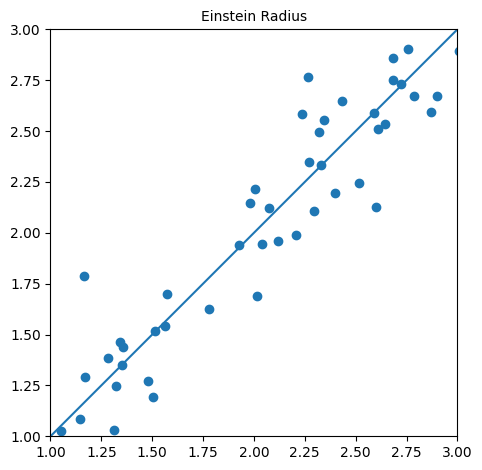

In [149]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

a, b = np.polyfit(preds[0][:32], preds[0][:32], 1)

ax.scatter(preds[0][:64], reals[0][:64])
ax.plot(x, a*x+b)
ax.set_xlim(1, 3)
ax.set_ylim(1, 3)
ax.set_aspect('equal', 'box')
ax.set_title('Einstein Radius', fontsize=10)

fig.tight_layout()

plt.show()

In [166]:
root = "__local/data/Cosmosim/empirical"
test_data = CosmosimImageDataset(
    root=root,
    img_dir="images/processed",
    all=True,
    transform=transform,
    target_transform=Lambda(lambda y: torch.tensor(y.astype(float).values))
)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

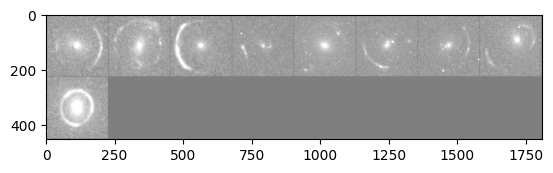

In [168]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

In [176]:
def simulate(grid, lens_galaxy, source_galaxy, simulator, shape=100):

    tracer = al.Tracer.from_galaxies(
        galaxies=[lens_galaxy, source_galaxy]
    )

    dataset = simulator.via_tracer_from(tracer=tracer, grid=grid)

    data = np.array(dataset.data)

    # Choose the lower and upper percentiles for normalization
    lower_percentile = 1
    upper_percentile = 95

    # Calculate the lower and upper limits for normalization
    lower_limit = np.percentile(data, lower_percentile)
    upper_limit = np.percentile(data, upper_percentile)

    # Clip and normalize the data to the 0-255 range
    normalized_data = np.clip(data, lower_limit, upper_limit)
    normalized_data = ((normalized_data - lower_limit) / (upper_limit - lower_limit) * 255).astype(np.uint8)

    normalized_data = normalized_data.reshape(shape,shape)

    im = Image.fromarray(normalized_data).convert('L')
    # im = im.resize((400,400))

    return im

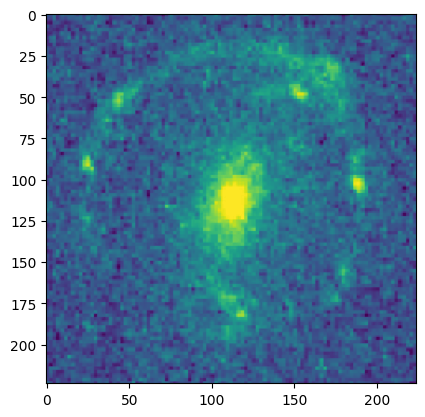

tensor([ 3.1613,  0.5329,  1.4147,  0.2839,  0.0328,  0.1572, -0.0909,  0.1084,
        -0.2949,  1.4202,  1.9347,  0.6490,  0.4254,  0.1744, -0.0625,  0.1378,
         0.8530], grad_fn=<SelectBackward0>)
['r_ein', 'rdsf_l', 'r_eff_l', 'x_l', 'y_l', 'ellx_l', 'elly_l', 'ellxl_l', 'ellyl_l', 'int_l', 'rdsf_s', 'r_eff_s', 'x_s', 'y_s', 'ellx_s', 'elly_s', 'int_s']


In [179]:
outputs = model(images)
i = 1
imshow(images[i])
print(outputs[i])
print(test_data.classes)

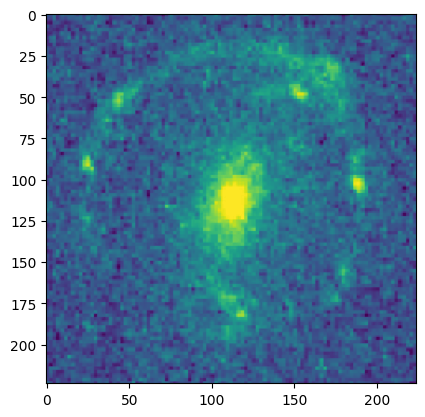

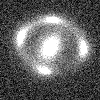

In [208]:
outputs = model(images)
outputs = outputs.detach().numpy()
i = 1

shape = 100
scale = 10 / shape

grid = al.Grid2D.uniform(
    shape_native=(shape, shape), 
    pixel_scales=scale
)

psf = al.Kernel2D.from_gaussian(
    shape_native=(21, 21), 
    sigma=0.1, 
    pixel_scales=grid.pixel_scales
)

simulator = al.SimulatorImaging(
    exposure_time=720.0, 
    psf=psf, 
    background_sky_level=100, 
    add_poisson_noise=True
)

lens = al.Galaxy(
    redshift=outputs[i][1],
    bulge=al.lp.Sersic(
        centre=(outputs[i][3], outputs[i][4]),
        ell_comps=(outputs[i][5], outputs[i][6]),
        intensity=outputs[i][9],
        effective_radius=outputs[i][2],
        sersic_index=1
    ),
    mass=al.mp.Isothermal(
        centre=(outputs[i][3], outputs[i][4]), einstein_radius=outputs[i][0], ell_comps=(outputs[i][7], outputs[i][8])
    ),
)

source = al.Galaxy(
    redshift=outputs[i][10],
    bulge=al.lp.Sersic(
        centre=(outputs[i][12], outputs[i][13]),
        ell_comps=(outputs[i][14], outputs[i][15]),
        intensity=outputs[i][16],
        effective_radius=outputs[i][11],
        sersic_index=1.5,
    ),
)

imshow(images[i])
simulate(grid, lens, source, simulator, shape)